C:\Users\86151\AppData\Local\Temp\ipykernel_14228\2039781745.py:209: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # 调整tight_layout以考虑颜色条的空间


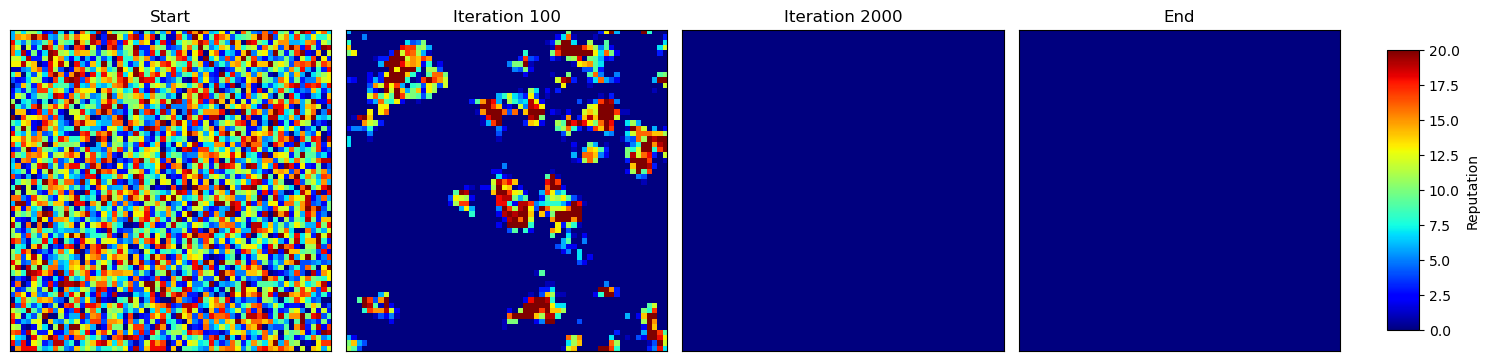

In [28]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd


def fermi_function(delta_payoff, beta):
    return 1 / (1 + np.exp(beta * delta_payoff))


def assign_strategies_random(G):
    num_nodes = len(G.nodes())
    strategies = [0] * (num_nodes // 2) + [1] * (num_nodes // 2)
    random.shuffle(strategies)

    for node, strategy in zip(G.nodes(), strategies):
        G.nodes[node]['strategy'] = strategy


def initialize_reputation(G):
    for node in G.nodes():
        G.nodes[node]['reputation'] = random.randint(0, 20)


def update_reputation(G):
    for node in G.nodes():
        if G.nodes[node]['strategy'] == 1:
            G.nodes[node]['reputation'] += 1
        elif G.nodes[node]['strategy'] == 0:
            G.nodes[node]['reputation'] -= 1

        G.nodes[node]['reputation'] = max(0, min(20, G.nodes[node]['reputation']))


def calculate_payoff_single(node, neighbors, r):
    neighbor_strategies = [G.nodes[neighbor]['strategy'] for neighbor in neighbors]
    defect_count = neighbor_strategies.count(0)
    cooperation_count = neighbor_strategies.count(1)
    N = cooperation_count + defect_count

    if cooperation_count == 0:
        cooperat_payoff = 0
        defect_payoff = 0
    else:
        defect_payoff = (r * cooperation_count) / N
        cooperat_payoff = defect_payoff - 1

    if G.nodes[node]['strategy'] == 0:
        return defect_payoff
    else:
        return cooperat_payoff


def play_game(G, r):
    payoffs = {}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        neighbors.append(node)
        payoffs[node] = calculate_payoff_single(node, neighbors, r)
    for node in G.nodes():
        G.nodes[node]['payoff'] = payoffs[node]


def evolutionary_game_async(G, t, r, beta, reputation_threshold, b):
    strategy_proportions_all = {'Cooperate': [], 'Defect': []}
    reputation_snapshots = []

    for _ in range(1):
        assign_strategies_random(G)
        initialize_reputation(G)

        strategy_proportions = {'Cooperate': [], 'Defect': []}

        def record_strategy_proportions(layer, strategy_proportions):
            strategy_counts = {'Cooperate': 0, 'Defect': 0}
            for node in layer.nodes():
                strategy_counts['Cooperate' if layer.nodes[node]['strategy'] == 1 else 'Defect'] += 1
            strategy_proportions['Cooperate'].append(strategy_counts['Cooperate'] / len(layer.nodes()))
            strategy_proportions['Defect'].append(strategy_counts['Defect'] / len(layer.nodes()))

        record_strategy_proportions(G, strategy_proportions)

        for node in G.nodes():
            G.nodes[node]['payoff'] = 0

        snapshots = []
        snapshots.append(np.array([G.nodes[node]['strategy'] for node in G.nodes()]).reshape(L, L))

        for iteration in range(t):
            for _ in range(3600):
                selected_nodes = random.sample(list(G.nodes()), 1)
                for node in selected_nodes:
                    neighbors = list(G.neighbors(node))
                    neighbors.append(node)
                    neighbor_reputations = [G.nodes[neighbor]['reputation'] for neighbor in neighbors]
                    total_reputation = sum(neighbor_reputations)

                    # 随机选择邻居
                    selected_neighbor = random.choice(neighbors)

                    average_reputation = sum(neighbor_reputations) / len(neighbor_reputations)

                    neighbor_strategies = [G.nodes[neighbor]['strategy'] for neighbor in neighbors]
                    cooperation_count = neighbor_strategies.count(1)
                    defect_count = neighbor_strategies.count(0)

                    if average_reputation < reputation_threshold:
                        for neighbor in neighbors:
                            if G.nodes[neighbor]['strategy'] == 0:
                                # 修改后的惩罚计算方式
                                a = (20 - (G.nodes[neighbor]['reputation'] / reputation_threshold))
                                b = 0.1
                                G.nodes[neighbor]['payoff'] -= b
                            # 计算适应度
                            c = 0.5
                            my_fitness = c * G.nodes[node]['payoff'] + (1 - c) * (
                                        G.nodes[node]['reputation'] - 0) / 20
                            neighbor_fitness = c * G.nodes[selected_neighbor]['payoff'] + (1 - c) * (
                                        G.nodes[selected_neighbor]['reputation'] - 0) / 20
                            delta_fitness = my_fitness - neighbor_fitness
                            prob_change = fermi_function(delta_fitness, beta)
                        if random.random() < prob_change:
                            new_strategy = G.nodes[selected_neighbor]['strategy']
                            G.nodes[node]['strategy'] = new_strategy
                    else:
                        # 计算适应度
                        c = 0.5
                        my_fitness = c * G.nodes[node]['payoff'] + (1 - c) * (
                                    G.nodes[node]['reputation'] - reputation_threshold) / 20
                        neighbor_fitness = c * G.nodes[selected_neighbor]['payoff'] + (1 - c) * (
                                    G.nodes[selected_neighbor]['reputation'] - reputation_threshold) / 20
                        delta_fitness = my_fitness - neighbor_fitness
                        prob_change = fermi_function(delta_fitness, beta)
                        if random.random() < prob_change:
                            new_strategy = G.nodes[selected_neighbor]['strategy']
                            G.nodes[node]['strategy'] = new_strategy

            play_game(G, r)
            update_reputation(G)

            record_strategy_proportions(G, strategy_proportions)

            if iteration == 0 or iteration == 99 or iteration == 1999 or iteration == t - 1:
                snapshots.append(np.array([G.nodes[node]['strategy'] for node in G.nodes()]).reshape(L, L))
                reputation_matrix = np.array([G.nodes[node]['reputation'] for node in G.nodes()]).reshape(L, L)
                reputation_snapshots.append(reputation_matrix)
                df = pd.DataFrame(reputation_matrix)
                if iteration == 0:
                    df.to_excel('reputation_start.xlsx', index=False, header=False)
                elif iteration == 99:
                    df.to_excel('reputation_iteration_99.xlsx', index=False, header=False)
                elif iteration == 1999:
                    df.to_excel('reputation_iteration_1999.xlsx', index=False, header=False)
                elif iteration == t - 1:
                    df.to_excel('reputation_end.xlsx', index=False, header=False)

        for strategy in ['Cooperate', 'Defect']:
            if len(strategy_proportions_all[strategy]) == 0:
                strategy_proportions_all[strategy] = np.array(strategy_proportions[strategy])
            else:
                strategy_proportions_all[strategy] += np.array(strategy_proportions[strategy])

    strategy_proportions_avg = {'Cooperate': [], 'Defect': []}
    for strategy in ['Cooperate', 'Defect']:
        strategy_proportions_avg[strategy] = strategy_proportions_all[strategy]

    return strategy_proportions_avg, snapshots, reputation_snapshots


L = 60
G = nx.grid_2d_graph(L, L, periodic=True)
t = 10000
r = 2.5
beta = 2
reputation_threshold = 0
b = 0.2

strategy_proportions, snapshots, reputation_snapshots = evolutionary_game_async(G, t, r, beta, reputation_threshold, b)

cmap_reputation = plt.cm.jet
norm = plt.Normalize(0, 20)

# 创建一个新的图形和坐标轴
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

for i, ax in enumerate(axs):
    im = ax.imshow(reputation_snapshots[i], cmap=cmap_reputation, interpolation='none', aspect='equal', norm=norm)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    if i == 0:
        ax.set_title('Start')
    elif i == 1:
        ax.set_title('Iteration 100')
    elif i == 2:
        ax.set_title('Iteration 2000')
    elif i == 3:
        ax.set_title('End')

# 调整布局，以便在图的右侧留出空间放置颜色条
plt.subplots_adjust(right=0.85)

# 在右侧创建垂直颜色图例
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # 调整颜色条的位置和大小
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('Reputation')

plt.tight_layout(rect=[0, 0, 0.85, 1])  # 调整tight_layout以考虑颜色条的空间
plt.show()

C:\Users\86151\AppData\Local\Temp\ipykernel_14228\3653856882.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


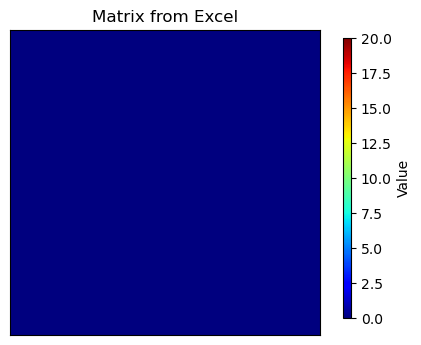

In [25]:
import pandas as pd
import matplotlib.pyplot as plt


# 读取 Excel 文件，这里假设数据在第一个工作表中
df = pd.read_excel('D:\\桌面\\FIRSTIDEA\\reputation_end.xlsx')

# 如果只需要整个工作表的矩阵数据，直接使用.values
reputation_snapshot = df.values

cmap_reputation = plt.cm.jet
# 设置颜色映射的范围从 0 到 20
norm = plt.Normalize(0, 20)

# 创建一个新的图形和坐标轴，这里只有一个子图
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

im = ax.imshow(reputation_snapshot, cmap=cmap_reputation, interpolation='none', aspect='equal', norm=norm)
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())
ax.set_title('Matrix from Excel')

# 调整布局，以便在图的右侧留出空间放置颜色条
plt.subplots_adjust(right=0.85)

# 在右侧创建垂直颜色图例
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('Value')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()
